# Embedding GPT


In [ ]:
# Install and upgrade required libraries:
# - openai: to access OpenAI API (embeddings)
# - pandas: for CSV data processing
# - tqdm: for progress bar visualization
!pip install --upgrade openai pandas tqdm

# Import required libraries
import pandas as pd
import json
from tqdm import tqdm
from openai import OpenAI
from google.colab import files

# Upload CSV file from local machine (Google Colab environment)
uploaded = files.upload()

# Get uploaded CSV file path and load it into a DataFrame
csv_path = list(uploaded.keys())[0]
df = pd.read_csv(csv_path)

# Print total number of records in the dataset
print("Jumlah data:", len(df))

# Initialize OpenAI client using API key
client = OpenAI(api_key="xxx")

# Function to combine social assistance type, question, and answer
# into a single text string for embedding generation
def make_text(row):
    return f"[{row['jenis_bansos']}] Q: {row['question']} A: {row['answer']}"

# Apply text combination function to each row
df["combined_text"] = df.apply(make_text, axis=1)

# List to store embedding results
embeddings = []

# Iterate through dataset with progress bar
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["combined_text"]

    # Generate embedding using OpenAI embedding model
    response = client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )

    # Extract embedding vector
    emb = response.data[0].embedding

    # Store original data along with its embedding
    embeddings.append({
        "id": int(row["id"]),
        "jenis_bansos": row["jenis_bansos"],
        "question": row["question"],
        "answer": row["answer"],
        "embedding": emb
    })

# Save embeddings into a JSON file
output_path = "embeddings.json"
with open(output_path, "w") as f:
    json.dump(embeddings, f, indent=2, ensure_ascii=False)

# Confirmation message after successful processing
print(f"Finish! File saved as: {output_path}")

# Download the generated embeddings file
files.download(output_path)

Saving dataset.csv to dataset (1).csv
Jumlah data: 664


100%|██████████| 664/664 [03:52<00:00,  2.85it/s]


Selesai! File disimpan sebagai: embeddings.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Dataset Redundancy


In [ ]:
# Import required libraries
from openai import OpenAI
import pandas as pd
import numpy as np
from tqdm import tqdm
from google.colab import files

# === 1. Load dataset ===
df = pd.read_csv("dataset_chroma.csv")
documents = (df["question"] + " " + df["answer"]).tolist()

if "id" not in df.columns:
    df["id"] = range(1, len(df) + 1)
ids = df["id"].tolist()

# === 2. Create OpenAI client ===
client = OpenAI(api_key="xxx")

# === 3. Generate embeddings using OpenAI ===
embeddings = []
for text in tqdm(documents, desc="Generating embeddings"):
    response = client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    embeddings.append(response.data[0].embedding)

embeddings = np.array(embeddings)

# === 4. Hitung cosine similarity ===
def cosine_similarity_matrix(vectors):
    norm = np.linalg.norm(vectors, axis=1, keepdims=True)
    normalized = vectors / norm
    return np.dot(normalized, normalized.T)

# Compute cosine similarity for all embeddings
cos_sim = cosine_similarity_matrix(embeddings)

# === 5. Identify redundant documents ===
# Define similarity threshold for redundancy detection
threshold = 0.8
redundant_pairs = []

# Compare each document pair and store highly similar ones
for i in range(len(documents)):
    for j in range(i + 1, len(documents)):
        if cos_sim[i, j] > threshold:
            redundant_pairs.append((ids[i], ids[j], float(cos_sim[i, j])))

# Print total number of redundant document pairs
print("Jumlah redundant pairs:", len(redundant_pairs))

# Display a subset of detected redundant pairs for inspection
for pair in redundant_pairs[:490]:
    print(f"🟡 ID {pair[0]} identical with ID {pair[1]}, score={pair[2]:.3f}")

# === 6. (Opsional) Save results ===
redundant_df = pd.DataFrame(redundant_pairs, columns=["id_1", "id_2", "similarity"])
redundant_df.to_csv("redundant_pairs_openai.csv", index=False)
print("Hasil disimpan di redundant_pairs_openai.csv")
files.download("redundant_pairs_openai.csv")


Generating embeddings: 100%|██████████| 672/672 [03:22<00:00,  3.32it/s]

Jumlah redundant pairs: 431
🟡 ID 1 mirip dengan ID 2, score=0.808
🟡 ID 2 mirip dengan ID 3, score=0.891
🟡 ID 2 mirip dengan ID 4, score=0.873
🟡 ID 2 mirip dengan ID 5, score=0.874
🟡 ID 2 mirip dengan ID 6, score=0.837
🟡 ID 2 mirip dengan ID 7, score=0.824
🟡 ID 3 mirip dengan ID 4, score=0.914
🟡 ID 3 mirip dengan ID 5, score=0.911
🟡 ID 3 mirip dengan ID 6, score=0.828
🟡 ID 3 mirip dengan ID 7, score=0.802
🟡 ID 4 mirip dengan ID 5, score=0.950
🟡 ID 4 mirip dengan ID 6, score=0.812
🟡 ID 5 mirip dengan ID 6, score=0.828
🟡 ID 5 mirip dengan ID 7, score=0.817
🟡 ID 6 mirip dengan ID 7, score=0.855
🟡 ID 6 mirip dengan ID 8, score=0.814
🟡 ID 9 mirip dengan ID 20, score=0.808
🟡 ID 11 mirip dengan ID 425, score=0.846
🟡 ID 22 mirip dengan ID 48, score=0.806
🟡 ID 26 mirip dengan ID 29, score=0.816
🟡 ID 31 mirip dengan ID 32, score=0.838
🟡 ID 33 mirip dengan ID 59, score=0.804
🟡 ID 34 mirip dengan ID 36, score=0.813
🟡 ID 34 mirip dengan ID 38, score=0.818
🟡 ID 34 mirip dengan ID 39, score=0.858
🟡 ID

# Deploy Openai


In [ ]:
# TRAINING 80%, VALIDATION 20%
# This script prepares a dataset, uploads it to OpenAI,
# and launches a fine-tuning job with an 80/20 data split.


# 1️ Install required libraries (ensure latest versions)
!pip install --upgrade openai pandas scikit-learn

# 2️ Import library
import pandas as pd
from sklearn.model_selection import train_test_split
from openai import OpenAI
import json

# 3️ Initialize OpenAI client
client = OpenAI(api_key="xxx")

# 4️ Upload dataset JSONL
from google.colab import files
uploaded = files.upload()

# Example "dataset_bansos.jsonl"
filename = list(uploaded.keys())[0]
print(f"File yang diupload: {filename}")

# 5️ Read JSONL dataset
df = pd.read_json(filename, lines=True)
print(f"Jumlah data total: {len(df)}")

# 6️ Split dataset: 80% training, 20% validation
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Save training and validation datasets as separate JSONL files
train_df.to_json("train_bansos.jsonl", orient="records", lines=True, force_ascii=False)
valid_df.to_json("valid_bansos.jsonl", orient="records", lines=True, force_ascii=False)

print(f"Training data: {len(train_df)} contoh")
print(f"Validation data: {len(valid_df)} contoh")

# 7️ Upload training and validation files to OpenAI
train_file = client.files.create(file=open("train_bansos.jsonl", "rb"), purpose="fine-tune")
valid_file = client.files.create(file=open("valid_bansos.jsonl", "rb"), purpose="fine-tune")

print("File uploaded successfully!")
print("Train file ID:", train_file.id)
print("Valid file ID:", valid_file.id)

# 8️ Create fine-tuning job
job = client.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=valid_file.id,
    model="gpt-4.1-nano-2025-04-14",
    suffix="bansos-2025",
    hyperparameters=
      {
        "batch_size": 32,
        "learning_rate_multiplier": 0.05,
        "n_epochs": 8
    }
)

print("Fine-tuning job success created!")
print("Job ID:", job.id)
print("Model dasar:", job.model)

# 9️ Check fine-tuning job status
status = client.fine_tuning.jobs.retrieve(job.id)
print(status)


Saving dataset_bansos_finetune.jsonl to dataset_bansos_finetune (4).jsonl
File yang diupload: dataset_bansos_finetune (4).jsonl
Jumlah data total: 664
Training data: 531 contoh
Validation data: 133 contoh
File berhasil diupload!
Train file ID: file-FveV5RztjE5bvmk6pgJ83W
Valid file ID: file-PFdYxr5dUPmTuYqFYNXvAt
Fine-tuning job berhasil dibuat!
Job ID: ftjob-ljZfUewmmMBESDPnBqb96pR4
Model dasar: gpt-4.1-nano-2025-04-14
FineTuningJob(id='ftjob-ljZfUewmmMBESDPnBqb96pR4', created_at=1761797496, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=8, learning_rate_multiplier=0.0002, n_epochs=3), model='gpt-4.1-nano-2025-04-14', object='fine_tuning.job', organization_id='org-0rKA6fCtHoIT37nZTBvZFdve', result_files=[], seed=939850971, status='validating_files', trained_tokens=None, training_file='file-FveV5RztjE5bvmk6pgJ83W', validation_file='file-PFdYxr5dUPmTuYqFYNXvAt', estimated_finish=None, integrations=[],

# Create Dataset JSONL

In [ ]:
!pip install --upgrade openai pandas scikit-learn

import pandas as pd
import json
from google.colab import files

# 1️ Upload file CSV
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 2️ Load CSV dataset
# Replace filename if your CSV file uses a different name
df = pd.read_csv("dataset.csv")
print("Contoh data:")
print(df.head())

# Define required columns for fine-tuning dataset
required_cols = ['tahun', 'jenis_bansos', 'source', 'question', 'answer']

# Validate that all required columns exist in the CSV file
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Kolom '{col}' tidak ditemukan di dataset CSV kamu!")

# 3️ Create JSONL file for fine-tuning
output_file = "dataset_bansos_finetune.jsonl"
with open(output_file, "w", encoding="utf-8") as f:
    for _, item in df.iterrows():
        record = {
            "messages": [
                {
                    "role": "system",
                    "content": (
                        f"Kamu adalah asisten virtual Kementerian Sosial Republik Indonesia. "
                        f"Tugas kamu menjelaskan dengan bahasa yang santai dan mudah dimengerti oleh masyarakat umum tentang program bantuan sosial '{item['jenis_bansos']}'."
                        "Jawaban kamu harus rinci, jelas, dan membantu orang paham langkah atau ketentuannya, "
                        "tapi jangan pakai bahasa hukum atau istilah rumit. "
                        "Kamu hanya boleh menjawab berdasarkan isi data yang ada di sistem (peraturan, keputusan, atau pedoman resmi). "
                        "Kalau informasinya nggak ada di data, jawab: 'Maaf, saya belum punya informasi itu di data saya.'"
                    )
                },
                {"role": "user", "content": str(item["question"])},
                {"role": "assistant", "content": f"Untuk program {item['jenis_bansos']}, {item['answer']}"}
            ]
        }
        f.write(json.dumps(record, ensure_ascii=False) + "\n")

print(f"Dataset berhasil dikonversi ke {output_file} untuk fine-tuning!")

# 4️ Download generated JSONL file
files.download(output_file)

Saving dataset.csv to dataset.csv
Contoh data:
   id  tahun                                             source jenis_bansos  \
0   1   2024  Keputusan Direktur Jenderal Rehabilitasi Sosia...   PERMAKANAN   
1   2   2012  Peraturan Pemerintah Republik Indonesia Nomor ...          PBI   
2   3   2024  Keputusan Direktur Jenderal Perlindungan Dan J...          PKH   
3   4   2018  Peraturan Menteri Sosial Republik Indonesia No...          PKH   
4   5   2024  Keputusan Direktur Jenderal Rehabilitasi Sosia...   PERMAKANAN   

                               question  \
0  Apa itu orang dengan HIV atau ODHIV?   
1             Apa itu pemerintah pusat?   
2                       Apa itu lansia?   
3                                ekanis   
4                    Apa itu Ahli Gizi?   

                                              answer  length  
0            ODHIV adalah orang yang terinfeksi HIV.      75  
1  Pemerintah pusat adalah presiden republik indo...      77  
2  Lansia adalah seseora

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Chroma DB


In [ ]:
import gdown, unicodedata, os, shutil, re, pandas as pd
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import SentenceTransformerEmbeddings
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

url = "https://drive.google.com/uc?id=1SsF541WzYaoSGUafc06MRPAy4VlxHdu1"
output = "dataset_chroma.csv"
gdown.download(url, output, quiet=False)
df = pd.read_csv(output)

print("===== Dataset Loaded =====")
print("Rows total:", len(df))
print("Available columns:", df.columns.tolist())
print(df.head(3))

# -----------------------------
# 1. USe "answer" column as text chunk
# -----------------------------
# TEXT_COL is used as the main chunk content for analysis
# QUESTION_COL is used to count available question-answer pairs
TEXT_COL = "answer"
QUESTION_COL = "question"

# -----------------------------
# 2. Compute token length
# -----------------------------
# Initialize tokenizer from sentence-transformers model
# Token length is used to analyze chunk size distribution
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Calculate token length for each answer
df["token_length"] = df[TEXT_COL].apply(
    lambda x: len(tokenizer.encode(str(x))) if isinstance(x, str) else 0
)

print("\n===== Statistik Token Length =====")
print(df["token_length"].describe())

# -----------------------------
# 3. Compute average lexical overlap between answers
# -----------------------------
# This function calculates word-level overlap between two text entries
def get_overlap(a, b):
    if not isinstance(a, str) or not isinstance(b, str):
        return 0
    return len(set(a.split()) & set(b.split()))

# Measure overlap between consecutive answer entries
overlaps = []
for i in range(len(df) - 1):
    overlaps.append(get_overlap(df.loc[i, TEXT_COL], df.loc[i + 1, TEXT_COL]))

# Compute average overlap score
avg_overlap = sum(overlaps) / len(overlaps) if overlaps else 0
print("\nRata-rata overlap antar answer:", avg_overlap)

# -----------------------------
# 4. Count number of Q–A pairs
# -----------------------------
# Count non-null questions to estimate dataset completeness
num_qa = df[QUESTION_COL].notnull().sum()
print("Jumlah QA pairs:", num_qa)

print("\n===== ANALYSYS COMPLETED =====")

Downloading...
From: https://drive.google.com/uc?id=1SsF541WzYaoSGUafc06MRPAy4VlxHdu1
To: /content/dataset_chroma.csv
100%|██████████| 304k/304k [00:00<00:00, 2.38MB/s]


===== Dataset Loaded =====
Jumlah baris: 664
Kolom tersedia: ['id', 'tahun', 'source', 'jenis_bansos', 'question', 'answer', 'length']
   id  tahun                                             source jenis_bansos  \
0   1   2024  Keputusan Direktur Jenderal Rehabilitasi Sosia...   PERMAKANAN   
1   2   2012  Peraturan Pemerintah Republik Indonesia Nomor ...          PBI   
2   3   2024  Keputusan Direktur Jenderal Perlindungan Dan J...          PKH   

                               question  \
0  Apa itu orang dengan HIV atau ODHIV?   
1             Apa itu pemerintah pusat?   
2                       Apa itu lansia?   

                                              answer  length  
0            ODHIV adalah orang yang terinfeksi HIV.      75  
1  Pemerintah pusat adalah presiden republik indo...      77  
2  Lansia adalah seseorang yang berumur 60 tahun ...      69  

===== Statistik Token Length =====
count    664.000000
mean     108.953313
std       75.657017
min       17.000000
25%

In [ ]:
!pip install -U chromadb langchain-community sentence-transformers Sastrawi gdown

import gdown, unicodedata, os, shutil, re, pandas as pd
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import SentenceTransformerEmbeddings
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Google Drive URL containing the dataset
url = "https://drive.google.com/uc?id=1SsF541WzYaoSGUafc06MRPAy4VlxHdu1"

# Local filename for the downloaded dataset
output = "dataset_chroma.csv"

# Download dataset from Google Drive
gdown.download(url, output, quiet=False)

# Load dataset into pandas DataFrame
df = pd.read_csv(output)

# === Preprocessing Tools ===
# Initialize Indonesian stemming and stopword removal tools
stemmer = StemmerFactory().create_stemmer()
stop_factory = StopWordRemoverFactory()
stopwords = set(stop_factory.get_stop_words())

def normalize_text(text: str) -> str:
    """Normalisasi teks: NKFC, lowercase, hapus simbol, stopword removal, stemming"""
    if pd.isna(text):
        return ""
    text = unicodedata.normalize("NFKC", str(text)).lower() # unicode normalize (hindari variasi aksara)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = " ".join([w for w in text.split() if w not in stopwords])
    # text = stemmer.stem(text)
    return text

# === Combine multiple columns into a single contextual document ===
# This creates richer semantic context for embedding
df["contextual_doc"] = (
    df["jenis_bansos"].astype(str) + " " +
    df["question"].astype(str) + " " +
    df["answer"].astype(str)
)

# Apply normalization to all documents
documents_s = df["contextual_doc"].apply(normalize_text).fillna("").astype(str)

# Remove empty documents after normalization
keep_mask = documents_s.str.len() > 0
df = df.loc[keep_mask].reset_index(drop=True)
documents_s = documents_s.loc[keep_mask].reset_index(drop=True)

# Remove duplicate documents to improve index efficiency
dedup = pd.DataFrame({"doc": documents_s})
dedup["row_idx"] = dedup.index
dedup = dedup.drop_duplicates(subset=["doc"])
keep_idx = set(dedup["row_idx"].tolist())

df = df.loc[df.index.isin(keep_idx)].reset_index(drop=True)
documents_s = documents_s.loc[documents_s.index.isin(keep_idx)].reset_index(drop=True)
documents = documents_s.tolist()

# Prepare metadata for each document
# Metadata is preserved for retrieval and answer grounding
def _safe(x):
    return "" if pd.isna(x) else str(x)

metadatas = [
    {
        "jenis_bansos": _safe(row["jenis_bansos"]),
        "question": _safe(row["question"]),
        "answer": _safe(row["answer"]),
    }
    for _, row in df.iterrows()
]

# Sanity check to ensure documents and metadata are aligned
assert len(documents) == len(metadatas) and len(documents) > 0

# === Embedding function (HuggingFace MiniLM, multilingual) ===
# This model balances performance and efficiency for semantic search
embedding_function = SentenceTransformerEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# === Chroma persistence directory ===
# Remove existing index to ensure a clean rebuild
CHROMA_DIR = "./chroma_bansos"
shutil.rmtree(CHROMA_DIR, ignore_errors=True)
os.makedirs(CHROMA_DIR, exist_ok=True)

# Build Chroma vector store from documents and metadata
db = Chroma.from_texts(
    texts=documents,
    metadatas=metadatas,
    embedding=embedding_function,
    persist_directory=CHROMA_DIR,
    collection_name="bansos_collection"
)
db.persist()

print("Index berhasil dibuat, total dokumen:", len(documents))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.2/471.2 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 134.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.2 MB/s et

Downloading...
From: https://drive.google.com/uc?id=1SsF541WzYaoSGUafc06MRPAy4VlxHdu1
To: /content/dataset_chroma.csv
100%|██████████| 304k/304k [00:00<00:00, 75.4MB/s]
/tmp/ipython-input-1706759477.py:73: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = SentenceTransformerEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab 

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Index berhasil dibuat, total dokumen: 664


/tmp/ipython-input-1706759477.py:87: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  db.persist()


In [ ]:
import re
import os
import torch
from langchain_community.vectorstores import Chroma
from sentence_transformers import CrossEncoder
from huggingface_hub import snapshot_download

# === 1) Local cache directory for HuggingFace models ===
# Using a local cache improves loading speed and avoids repeated downloads
HF_CACHE_DIR = "./model_cache"
os.makedirs(HF_CACHE_DIR, exist_ok=True)
os.environ["HF_HOME"] = HF_CACHE_DIR
os.environ["TRANSFORMERS_CACHE"] = HF_CACHE_DIR

# === 2) Global parameters ===
# Available reranker models
baai = "BAAI/bge-reranker-v2-m3"
miniLM = "cross-encoder/ms-marco-MiniLM-L-6-v2"
tinybert = "cross-encoder/ms-marco-TinyBERT-L-6"
ce_model = tinybert
top_k = 50
V_TRESHOLD = 4
CE_THRESHOLD = 0.1

# === 3) Global CrossEncoder loader (singleton pattern) ===
# The model is loaded once and reused to reduce overhead
_ce = None
def _get_cross_encoder(model_name: str):
    global _ce
    if _ce is None:
        cache_dir = HF_CACHE_DIR
        os.makedirs(cache_dir, exist_ok=True)

        print(f"[INFO] Memeriksa model cache untuk: {model_name}")
        snapshot_download(repo_id=model_name, cache_dir=cache_dir)

        device = "cpu"
        _ce = CrossEncoder(model_name, cache_folder=cache_dir, device=device)
    return _ce

# === 4) Common utility functions ===
def _detect_bansos(query: str, jenis_bansos_list):
    """
    Detect specific social assistance program mentioned in the user query.
    Returns the detected program name if found, otherwise None.
    """
    q = (query or "").lower()
    for jb in jenis_bansos_list:
        if jb.lower() in q:
            return jb
    return None

def _safe(x):
    """
    Safely convert values to string while handling NaN.
    """
    import pandas as pd
    return "" if pd.isna(x) else str(x)

# === 5) Main chatbot function ===
def ask_chatbot(query: str, db: Chroma, jenis_bansos_list):
    """
    Perform retrieval-augmented answering using:
    - Vector similarity search (Chroma)
    - Distance-based filtering
    - Cross-encoder re-ranking
    """
    query_norm = normalize_text(query)

    # Domain-specific filtering based on detected social assistance program
    detected_bansos = _detect_bansos(query, jenis_bansos_list)
    if detected_bansos:
        results = db.similarity_search_with_score(
            query_norm, k=top_k,
            filter={"$or": [{"jenis_bansos": detected_bansos}, {"jenis_bansos": "DTKS"}]}
        )
    else:
        results = db.similarity_search_with_score(
            query_norm + " DTKS", k=top_k, filter={"jenis_bansos": "DTKS"}
        )

    # Handle empty retrieval results
    if not results:
        return {"answer": "Tidak ada jawaban relevan.", "top": []}

    print(f"[INFO] Hasil awal (Top-K={top_k}) dari Chroma: {len(results)} dokumen")

    # Distance-based filtering
    # Keep documents within a relative distance threshold from the best result
    results = sorted(results, key=lambda x: x[1])
    best_dist = results[0][1]
    cutoff = best_dist + V_TRESHOLD
    filtered = [(d, s) for (d, s) in results if s <= cutoff][:30]  # <== batasi rerank max 30 dokumen
    print(f"[INFO] Setelah filter distance (≤ {cutoff:.3f}): {len(filtered)} dokumen")

    # Prepare query-document pairs for cross-encoder re-ranking
    pairs = []
    for (doc, _dist) in filtered:
        q_text = _safe(doc.metadata.get("question", ""))
        a_text = _safe(doc.metadata.get("answer", ""))
        pairs.append((query, f"Q: {q_text}\nA: {a_text}"))

    # Load cached cross-encoder and compute relevance scores
    ce = _get_cross_encoder(ce_model)
    with torch.no_grad():
        rerank_scores = ce.predict(pairs, batch_size=16)

    # Sort documents by cross-encoder relevance score (descending)
    reranked = sorted(zip(filtered, rerank_scores), key=lambda x: x[1], reverse=True)
    (best_doc, best_dist), best_ce = reranked[0]

    # Reject results if relevance score is below threshold
    if not reranked or best_ce < CE_THRESHOLD:
        return {"answer": "Tidak ada jawaban relevan.", "top": []}

    # Apply cross-encoder threshold filtering
    reranked = [item for item in reranked if item[1] >= CE_THRESHOLD]
    print(f"[INFO] Setelah CE_THRESHOLD filter: {len(reranked)} dokumen lolos")

    # Select top-ranked results
    top = reranked[:10]
    (best_doc, best_dist), best_ce = top[0]
    answer = best_doc.metadata.get("answer", "Tidak ada jawaban.")

    # Debug output for inspection and analysis
    print("\n=== TOP HASIL RERANKING ===")
    max_score = top[0][1] if top else 1.0
    print("\n=== TOP 10 HASIL RERANKING (PERSEN TERHADAP SKOR TERTINGGI) ===")
    for i, ((doc, dist), score) in enumerate(top, start=1):
        rel = (score / max_score * 100.0) if max_score else 0.0
        print(f"[{i}] {doc.metadata.get('jenis_bansos','-')} ({doc.metadata.get('tahun','-')})")
        print(f"    Dist (VDB) : {dist:.4f}")
        print(f"    CE Score   : {score:.4f} ({rel:.1f}%)")
        print(f"    Q: {doc.metadata.get('question','')}")
        print(f"    A: {doc.metadata.get('answer','')}\n")
    print("===============================================================\n")
    print("User:", query)

    # Final structured output
    return {
        "answer": answer,
        "top": [
            {
                "question": doc.metadata.get("question", ""),
                "answer": doc.metadata.get("answer", ""),
                "jenis_bansos": doc.metadata.get("jenis_bansos", ""),
                "distance": dist,
                "score_rerank": score
            }
            for ((doc, dist), score) in top
        ]
    }

# List of supported social assistance program types
jenis_bansos_list = ["BPNT", "PKH", "DTKS", "PBI", "PENA", "PERMAKANAN", "RST", "ATENSI"]


# API


In [ ]:
import os
from typing import Dict, Tuple, List
from openai import OpenAI

# ============================================================
# OpenAI client initialization
# Used ONLY for final answer generation, not retrieval
# ============================================================
client = OpenAI(api_key="xxx")

# ============================================================
# Domain-specific synonym normalization
# This ensures user queries map consistently to official
# regulatory terminology used in the dataset.
# ============================================================
similar_word_master: Dict[Tuple[str, ...], str] = {
    ("aplikasi cek bansos",): "aplikasi cekbansos",
    ("bansos", "bantuan", "bantuan pemerintah", "program sosial", "bansosnya"): "bantuan sosial",
    ("mekanisme",): "cara",
    ("penerima manfaat", "keluarga penerima manfaat"): "KPM",
    ("dihentikan", "pencabutan", "diberhentikan", "nonaktif", "penonaktifan", "menidaklayakkan"): "penghapusan",
    ("pengajuan", "pendaftaran", "daftar"): "pengusulan",
    ("melihat", "cek"): "pengecekan",
    ("tidak berhak", "tidak memenuhi syarat", "ineligible", "tidak masuk"): "tidak layak",
    ("memenuhi syarat", "berhak", "eligible"): "layak",

    ("data terpadu kesejahteraan sosial",): "DTKS",
    ("program keluarga harapan", "bansos keluarga"): "PKH",
    ("bantuan pangan non tunai", "sembako"): "BPNT",
    ("pemberdayaan ekonomi nasional",): "PENA",
    ("kis", "penerima bantuan iuran", "iuran"): 'PBI',
    ("rumah sejahtera terpadu",): 'RST',
    ("rumah layak huni",): 'RLH',
    ("yatim piatu",): 'ATENSI',

    ("sistem informasi kesejahteraan sosial",): "SIKSNG",
    ("Sistem Informasi Kesejahteraan Sosial Permakanan",): "SIKSMA",
    ("kementerian sosial",): "Kemensos",
    ("dinsos",): "dinas sosial",
}

# ============================================================
# Replace informal / synonymous terms with canonical forms
# Improves retrieval precision and recall
# ============================================================
def expand_with_similar_words(query: str, similar_dict: Dict[Tuple[str, ...], str]) -> str:
    all_pairs: List[Tuple[str, str]] = sorted(
        [(variant.strip(), main.strip()) for variants, main in similar_dict.items() for variant in variants],
        key=lambda x: len(x[0]), reverse=True
    )

    for variant, main in all_pairs:
        pattern = re.escape(variant)
        query = re.sub(rf"(?<!\w){pattern}(?!\w)", main, query, flags=re.IGNORECASE | re.UNICODE)

    return re.sub(r"\s+", " ", query).strip()

# ============================================================
# Build compact contextual evidence from top-K RAG results
# This context is the ONLY source of truth for the LLM
# ============================================================
def _build_context_from_topk(rag_top, k=5):
    """Satukan beberapa item top-K agar model punya konteks cukup, plus beri indeks untuk sitasi."""
    parts_full = []
    for i, it in enumerate(rag_top[:k], start=1):
        jb = (it.get("jenis_bansos") or "").strip()
        q  = (it.get("question") or "").strip()
        a  = (it.get("answer") or "").strip()

        parts_full.append(f"[{i}] ({jb})\nQ: {q}\nA: {a}")

    return "\n\n".join(parts_full)

# ============================================================
# Main inference pipeline
# Combines RAG retrieval with controlled LLM reasoning
# ============================================================
def run_inference_dtks(query: str, db, jenis_bansos_list, model) -> str:
    # --- Step 1: Normalize & expand query ---
    query = expand_with_similar_words(query, similar_word_master)

    # --- Step 2: Retrieve relevant documents using RAG ---
    rag = ask_chatbot(query, db, jenis_bansos_list)
    rag_top = rag.get("top", [])

    if not rag_top:
        return "Maaf, saya belum punya informasi itu di data saya."

    context_for_model = _build_context_from_topk(rag_top, k=5)

    # ========================================================
    # Strict system instruction to prevent hallucination
    # The model is forced to answer ONLY from legal documents
    # ========================================================
    system_msg = (
        "Kamu adalah Asisten Virtual Kementerian Sosial Republik Indonesia. "
        "Tugasmu memberikan informasi resmi terkait regulasi dan kebijakan bantuan sosial. "
        "WAJIB hanya mengambil informasi dari konteks regulasi yang diberikan.\n\n"
        "ATURAN KETAT:"
        "1. Dilarang menambah fakta baru atau menyimpulkan di luar konteks regulasi.\n"
        "2. Jika ditanya tentang alasan personal seseorang tidak menerima bantuan, jangan menebak. Sebagai gantinya, jelaskan cara-cara umum untuk memperoleh atau memastikan kelayakan bantuan sesuai ketentuan resmi.\n"
        "3. Jawaban harus naratif, mengalir, ramah, dan mudah dipahami masyarakat umum.\n"
        "4. Hindari penggunaan daftar bernomor; gunakan penghubung seperti 'lalu', 'selain itu', atau 'terakhir'.\n"
        "5. Tidak boleh memberikan langkah teknis penggunaan aplikasi (misal login/menu). "
        "6. Boleh menjelaskan prosedur administratif umum seperti pendaftaran, verifikasi data, pengecekan DTKS, atau mekanisme pengaduan berdasarkan regulasi.\n"
        "7. Jika topik atau prosedur tidak ada dalam dataset, jawab: 'Maaf, saya belum punya informasi itu di data saya.'\n"
        "8. Pastikan seluruh jawaban hanya berdasarkan isi dataset hukum yang tersedia."
    )

    # --- Step 3: Controlled OpenAI reasoning ---
    resp = client.chat.completions.create(
        model=model,
        messages = [
            {"role": "system", "content": system_msg},
            {"role": "assistant", "content": f"Berikut isi dataset yang relevan:\n {context_for_model or 'Tidak ada data relevan.'}"},
            {"role": "user", "content": query.strip()}
        ],
        temperature=0.0,
        top_p=0.5,
        max_tokens=250
    )
    final_text = resp.choices[0].message.content.strip()
    return final_text

# ============================================================
# Example execution
# ============================================================
hasil = run_inference_dtks(
    "bagaimana cara mengusulkan bansos pbi?",
    db=db,
    jenis_bansos_list=jenis_bansos_list,
    model="ft:gpt-4.1-nano-xxxx"
)
print("Bot :", hasil, "\n")
print("=====================")

[INFO] Hasil awal (Top-K=50) dari Chroma: 50 dokumen
[INFO] Setelah filter distance (≤ 9.003): 21 dokumen
[INFO] Memeriksa model cache untuk: cross-encoder/ms-marco-TinyBERT-L-6


Fetching 25 files:   0%|          | 0/25 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

onnx/model_O1.onnx:   0%|          | 0.00/268M [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/268M [00:00<?, ?B/s]

CERerankingEvaluator_results.csv: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

onnx/model.onnx:   0%|          | 0.00/268M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/445 [00:00<?, ?B/s]

onnx/model_O2.onnx:   0%|          | 0.00/268M [00:00<?, ?B/s]

onnx/model_O4.onnx:   0%|          | 0.00/134M [00:00<?, ?B/s]

onnx/model_O3.onnx:   0%|          | 0.00/268M [00:00<?, ?B/s]

onnx/model_qint8_arm64.onnx:   0%|          | 0.00/67.6M [00:00<?, ?B/s]

onnx/model_quint8_avx2.onnx:   0%|          | 0.00/67.6M [00:00<?, ?B/s]

openvino/openvino_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

openvino/openvino_model_qint8_quantized.(…):   0%|          | 0.00/67.6M [00:00<?, ?B/s]

openvino_model.xml: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

openvino_model_qint8_quantized.xml: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

train_script.py: 0.00B [00:00, ?B/s]

[INFO] Setelah CE_THRESHOLD filter: 21 dokumen lolos

=== TOP HASIL RERANKING ===

=== TOP 10 HASIL RERANKING (PERSEN TERHADAP SKOR TERTINGGI) ===
[1] DTKS (-)
    Dist (VDB) : 6.1535
    CE Score   : 0.9834 (100.0%)
    Q: Bagaimana cara pengusulan bantuan sosial?
    A: Masyarakat harus terdaftar pada DTKS melalui aplikasi Cekbansos atau mendatangi dinas sosial setempat.

[2] DTKS (-)
    Dist (VDB) : 8.9623
    CE Score   : 0.9793 (99.6%)
    Q: Bagaimana cara mengusulkan bantuan sosial untuk orang yang tidak punya identitas?
    A: Orang tersebut harus didaftarkan identitasnya ke dukcapil, setelah itu dinas sosial akan melakukan memasukkan data tersebut ke DTKS.

[3] PBI (-)
    Dist (VDB) : 8.1118
    CE Score   : 0.9773 (99.4%)
    Q: Bagaimana cara penambahan peserta PBI Jaminan Kesehatan jika kuota nasional belum terpenuhi?
    A: Jika peserta PBI jaminan kesehatan dari dinas sosial kabupaten kota belum mencapai kuota nasional, menteri sosial dapat menambah peserta pengganti. P

In [ ]:
!pip install -q rouge-score nltk sentence-transformers scikit-learn Sastrawi
import langchain
import sentence_transformers
from importlib.metadata import version
import sys

# ============================================================
# Display Python runtime version
# Important for reproducibility and compatibility reporting
# ============================================================
print(sys.version)

# ============================================================
# Print versions of key NLP and RAG-related libraries
# These versions should be reported in experiments or appendix
# ============================================================
print("LangChain:", langchain.__version__)
print("SentenceTransformer:", sentence_transformers.__version__)
print("Sastrawi:", version("Sastrawi"))

# ============================================================
# Display GPU information (if available)
# Used to verify hardware acceleration support
# ============================================================
!nvidia-smi


3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
LangChain: 0.3.27
SentenceTransformer: 5.1.2
Sastrawi: 1.0.1
Fri Nov 14 08:27:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                           

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
Downloading...
From: https://drive.google.com/uc?id=1mRGG01TQ_6FhfW4HZGOd85a-sCrfsUUS
To: /content/evaluasi_dataset.xlsx
100%|██████████| 23.7k/23.7k [00:00<00:00, 7.26MB/s]


Jumlah sampel: 39


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


=== Ringkasan Rata-rata ===
Precision           : 0.8370
Recall              : 0.8657
F1                  : 0.8452
Cosine Similarity   : 0.9287
BLEU                : 0.7175
ROUGE-1             : 0.8452
ROUGE-2             : 0.6885
ROUGE-L             : 0.7901


,query,Precision,Recall,F1,Cosine_Similarity,BLEU,ROUGE-1,ROUGE-2,ROUGE-L
0,cara daftar dtks gimana?,0.931034,0.964286,0.947368,0.914690,0.874516,0.947368,0.836364,0.947368
1,bagaimana cara mengusulkan bansos BPNT,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,cara mendaftarkan aplikasi cekbansos,1.000000,0.928571,0.962963,0.978684,0.828205,0.962963,0.769231,0.888889
3,bagaiamana cara perbaikan untuk pergantian pen...,0.966667,1.000000,0.983051,0.990546,0.912871,0.983051,0.877193,0.915254
4,bagaimana cara untuk merubah alamat domisili a...,0.714286,1.000000,0.833333,0.910975,0.514344,0.833333,0.434783,0.583333
5,cara mendaftarkan PBI,0.722222,0.764706,0.742857,0.938650,0.574594,0.742857,0.470588,0.628571
6,kenapa tidak masuk dtks,0.743590,0.580000,0.651685,0.886846,0.408627,0.651685,0.344828,0.494382
7,kenapa lansia tidak menerima bantuan program PKH,0.650000,0.928571,0.764706,0.937463,0.483046,0.764706,0.424242,0.617647
8,kenapa tidak mendapatkan bansos PKH padahal su...,0.893617,0.913043,0.903226,0.988859,0.812711,0.903226,0.747253,0.860215
9,kenapa orang mampu masih menerima bantuan,0.600000,0.558140,0.578313,0.811104,0.460290,0.578313,0.395062,0.506024


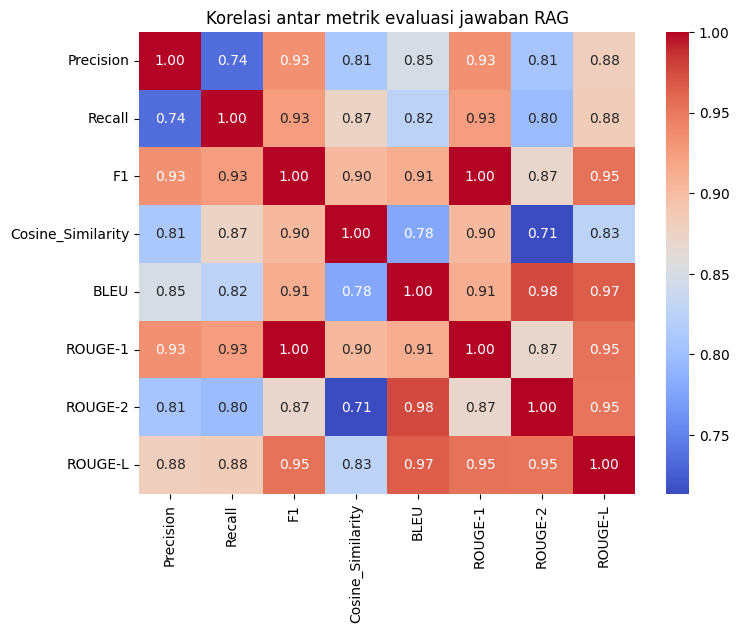

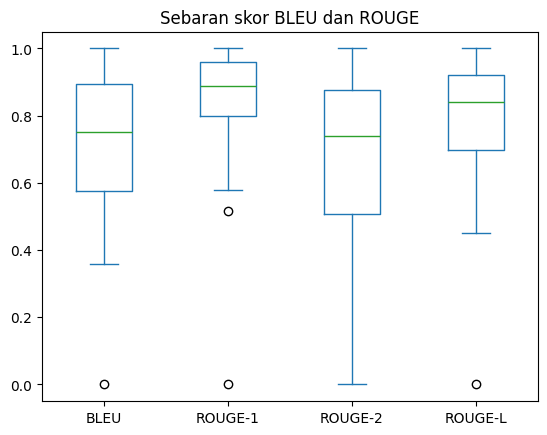

In [ ]:
!pip install -q rouge-score nltk sentence-transformers scikit-learn Sastrawi

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re, string
import matplotlib.pyplot as plt
import nltk
import gdown
from sklearn.metrics import precision_score, recall_score, f1_score
from sentence_transformers import SentenceTransformer, util
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from google.colab import files
from nltk.stem import WordNetLemmatizer

# ============================================================
# Download NLTK resources
# ============================================================
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# ============================================================
# Load evaluation dataset
# ============================================================
url = "https://drive.google.com/uc?id=1mRGG01TQ_6FhfW4HZGOd85a-sCrfsUUS"
filename = "evaluasi_dataset.xlsx"
gdown.download(url, filename, quiet=False)
df = pd.read_excel(filename)

# ============================================================
# Text normalization tools (Bahasa Indonesia)
# ============================================================
stemmer = StemmerFactory().create_stemmer()
stop_factory = StopWordRemoverFactory()
stopwords = set(stop_factory.get_stop_words())
lemmatizer = WordNetLemmatizer()

# Domain-specific synonym normalization
synonym_map = {
    ("aplikasi cek bansos",): "aplikasi cekbansos",
    ("bansos", "bantuan", "bantuan pemerintah", "program sosial", "bansosnya"): "bantuan sosial",
    ("mekanisme",): "cara",
    ("penerima manfaat", "keluarga penerima manfaat"): "kpm",
    ("dihentikan", "pencabutan", "diberhentikan", "nonaktif", "penonaktifan", "menidaklayakkan"): "penghapusan",
    ("pengajuan", "pendaftaran", "daftar"): "pengusulan",
    ("melihat", "cek"): "pengecekan",
    ("tidak berhak", "tidak memenuhi syarat", "ineligible", "tidak masuk"): "tidak layak",
    ("memenuhi syarat", "berhak", "eligible"): "layak",

    ("data terpadu kesejahteraan sosial",): "dtks",
    ("program keluarga harapan", "bansos keluarga"): "pkh",
    ("bantuan pangan non tunai", "sembako"): "bpnt",
    ("pemberdayaan ekonomi nasional",): "pena",
    ("kis", "penerima bantuan iuran", "iuran"): "pbi",
    ("rumah sejahtera terpadu",): "rst",
    ("rumah layak huni",): "rlh",
    ("yatim piatu",): "atensi",

    ("sistem informasi kesejahteraan sosial",): "siksng",
    ("sistem informasi kesejahteraan sosial permakanan",): "siksma",
    ("kementerian sosial",): "kemensos",
    ("dinsos",): "dinas sosial",
}

custom_stop = {"itu","adalah","jika","atau","oleh","untuk","pada","saja","dengan"}

# ============================================================
# Text normalization function
# ============================================================
def normalize_text(text):
    """
    Normalize Indonesian text using:
    - Lowercasing
    - Synonym replacement
    - Punctuation removal
    - Stopword removal
    - Stemming
    """
    if not isinstance(text, str):
        return ""
    text = text.lower().strip()

    # Apply domain-specific synonym rules
    for keys, value in synonym_map.items():
        for term in sorted(keys, key=len, reverse=True):
            pattern = r"\b" + re.escape(term.lower()) + r"\b"
            text = re.sub(pattern, value.lower(), text)

    text = re.sub(r"["+string.punctuation+"]", " ", text) # Remove punctuation
    tokens = text.split() # Tokenize (PER KATA, bukan per huruf)
    tokens = [w for w in tokens if w not in stopwords and w not in custom_stop] # Remove stopwords
    tokens = [stemmer.stem(w) for w in tokens] # Stemming
    tokens = list(dict.fromkeys(tokens)) # Deduplicate sequentially
    return " ".join(tokens)

# Normalize gold answers and RAG answers
df["gold_norm"] = df["gold_answer"].apply(normalize_text)
df["rag_norm"] = df["rag_answer"].apply(normalize_text)

# ========== Precision, Recall, F1 ==========
def keyword_overlap_score(pred, gold):
    pred_tokens = set(pred.split())
    gold_tokens = set(gold.split())
    overlap = len(pred_tokens & gold_tokens)
    precision = overlap / len(pred_tokens) if pred_tokens else 0
    recall = overlap / len(gold_tokens) if gold_tokens else 0
    f1 = 2 * precision * recall / (precision + recall) if precision+recall > 0 else 0
    return precision, recall, f1

precisions, recalls, f1s = [], [], []
for _, row in df.iterrows():
    p, r, f = keyword_overlap_score(row["rag_norm"], row["gold_norm"])
    precisions.append(p); recalls.append(r); f1s.append(f)

df["Precision"] = precisions
df["Recall"] = recalls
df["F1"] = f1s

# ========== Cosine Similarity (Semantik Similarity)==========
def cosine_similarity_score(pred, gold, model):
    pred_embedding = model.encode(pred, convert_to_tensor=True)
    gold_embedding = model.encode(gold, convert_to_tensor=True)
    cosine_sim = util.pytorch_cos_sim(pred_embedding, gold_embedding)
    return cosine_sim.item()

model = SentenceTransformer('all-MiniLM-L6-v2')  # contoh model pre-trained
df['Cosine_Similarity'] = df.apply(lambda row: cosine_similarity_score(row['rag_norm'], row['gold_norm'], model), axis=1)

# ========== BLEU Score ==========
smooth = SmoothingFunction().method1
bleu_scores = []
for _, row in df.iterrows():
    ref = [row["gold_norm"].split()]
    cand = row["rag_norm"].split()
    bleu = sentence_bleu(ref, cand, weights=(0.5, 0.5), smoothing_function=smooth)
    bleu_scores.append(bleu)
df["BLEU"] = bleu_scores

# ========== ROUGE ==========
rouge1_list, rouge2_list, rougeL_list = [], [], []
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
for _, row in df.iterrows():
    scores = scorer.score(row["gold_norm"], row["rag_norm"])
    rouge1_list.append(scores["rouge1"].fmeasure)
    rouge2_list.append(scores["rouge2"].fmeasure)
    rougeL_list.append(scores["rougeL"].fmeasure)

df["ROUGE-1"] = rouge1_list
df["ROUGE-2"] = rouge2_list
df["ROUGE-L"] = rougeL_list

# ========== Summary statistics ==========
summary = {
    "Precision": np.mean(df["Precision"]),
    "Recall": np.mean(df["Recall"]),
    "F1": np.mean(df["F1"]),
    "Cosine Similarity": np.mean(df["Cosine_Similarity"]),
    "BLEU": np.mean(df["BLEU"]),
    "ROUGE-1": np.mean(df["ROUGE-1"]),
    "ROUGE-2": np.mean(df["ROUGE-2"]),
    "ROUGE-L": np.mean(df["ROUGE-L"])
}

print("\n=== Ringkasan Rata-rata ===")
for k, v in summary.items():
    pri``nt(f"{k:20s}: {v:.4f}")
display(df[["query", "Precision", "Recall", "F1", "Cosine_Similarity", "BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L"]])

# === Correlation analysis between evaluation metrics ===
corr = df[["Precision", "Recall", "F1", "Cosine_Similarity", "BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasi antar metrik evaluasi jawaban RAG")
plt.show()

# === Distribution visualization ===
df[["BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L"]].plot(kind='box', title='Sebaran skor BLEU dan ROUGE')
plt.show()

In [ ]:
# API untuk Chatbot RAG + Memory
!pip install fastapi uvicorn nest_asyncio pyngrok --quiet

import nest_asyncio
import uvicorn
from fastapi import FastAPI, Request
from pydantic import BaseModel
from pyngrok import ngrok

# ============================================================
# Enable nested asyncio
# Initialize FastAPI application
# Required when running FastAPI inside environments like Google Colab
# ============================================================
nest_asyncio.apply()
app = FastAPI()

# ============================================================
# Define request schema using Pydantic
# This ensures incoming requests follow a strict JSON format
# ============================================================
class Query(BaseModel):
    question: str

# ============================================================
# API endpoint for chatbot inference
# Receives a user question, runs RAG + memory pipeline,
# and returns the generated answer
# ============================================================
@app.post("/ask")
async def ask(query: Query):
    user_question = query.question
    answer = ask_chatbot_with_memory(user_question, db, jenis_bansos_list)
    return {"question": user_question, "answer": answer}

# ============================================================
# Configure ngrok authentication
# Ngrok is used to expose the local FastAPI server
# to a public URL for testing or integration
# ============================================================
ngrok.set_auth_token("xxx")

# ============================================================
# Create a public tunnel to the local FastAPI server
# ============================================================
public_url = ngrok.connect(8000)
print("Public API URL:", public_url)

# ============================================================
# Run FastAPI application using Uvicorn
# The server listens on all interfaces at port 8000
# ============================================================
uvicorn.run(app, host="0.0.0.0", port=8000)